In [1]:
from MPyDATA.mpdata import MPDATA
from MPyDATA.coord import x_id, x_ln, x_p2
import numpy as np

In [2]:
from matplotlib import pyplot 
%matplotlib inline

import pint
si = pint.UnitRegistry()
si.setup_matplotlib()

tunit = si.second
xunit = si.micrometre
yunit = 1 / si.micrometre / si.centimetre**3
cdfunit = yunit * xunit

def xmgn(x):
    return x.to(xunit).magnitude

def tmgn(t):
    return t.to(tunit).magnitude

def fmgn(fun, unit):
    return lambda x: fun(x * xunit).to(unit).magnitude

def diff(x):
    return np.diff(x.magnitude) * x.units

In [3]:
class plotter:
    def __init__(self, r_min, r_max):
        self.cdfarg, self.dcdfarg = np.linspace(
            r_min,
            r_max,
            512, retstep=True
        )
        pyplot.figure(figsize=(8, 6))

    def done(self, title):
        pyplot.title(title)
        pyplot.gca().xaxis.set_units(si.micrometre)
        pyplot.gca().yaxis.set_units(1 / si.micrometre / si.centimetre**3)
        pyplot.grid()
        pyplot.legend()
        pyplot.show()

    def pdf_cdf(self, cdf):
        x = self.cdfarg[0:-1] + (self.cdfarg[1:] - self.cdfarg[0:-1]) / 2
        y = np.diff(cdf(self.cdfarg)) / self.dcdfarg
        pyplot.plot(x * xunit, y * yunit)

    def pdf_pdf(self, pdf):
        x = self.cdfarg 
        y = pdf(x)
        pyplot.plot(x * xunit, y * yunit, 'k:')

    def step(self, algo, t):
        o = algo.opts
        label = f"t={t} n_it={o['n_it']} dfl={o['dfl']} tot={o['tot']} iga={o['iga']} fct={o['fct']}"
        pyplot.step(algo.state.r * xunit, algo.state.pdf * yunit, linestyle='-', where='mid', label=label)


In [20]:
class Setup:
    nr = 64
    nt = 500
    dt = .01 * si.second
    r_min = 1 * si.micrometre
    r_max = 25 * si.micrometre

    # Fair weather cummuli case (East & Marshall 1954)
    pdf0 = lambda r: (
        (700 * si.micrometre) / r * 
        np.exp(-22 * (np.log10(r / (7 * si.micrometre))**2)) *
        (1 / si.centimetre**3 / si.micrometre)
    )
    cdf0 = lambda r: (
        175 * np.sqrt(2 * np.pi / 11) * 
        np.erf(np.sqrt(22) * np.log(r / (7 * si.micrometre))/ np.log(10)) * 
        np.log(10) *
        (1 / si.centimetre**3)
    )

    # Rogers and Yau p. 104
    ksi_1 = 68.2 * si.micrometre ** 2 / si.second
    S = 1.05
    ksi = (S - 1) * ksi_1
    drdt = lambda r: Setup.ksi / r

    @staticmethod
    def Rogers(r):
        with np.errstate(invalid='ignore'):
            arg = np.sqrt(r ** 2 - 2 * Setup.ksi * Setup.nt * Setup.dt)
        return r / arg * Setup.pdf0(arg)


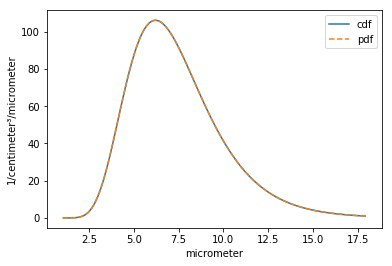

In [22]:
# Fig 3 from East & Marshall 1954
x = np.linspace(1,18,100) * si.micrometre
pyplot.plot(x[1:] - diff(x)/2, diff(Setup.cdf0(x)) / diff(x), label='cdf')
pyplot.plot(x, Setup.pdf0(x), label='pdf', linestyle='--')
pyplot.legend()

In [23]:
def run(setup):
    s = setup
    result = {}
    for fn in (x_id, x_p2, x_ln):
        algos = (
            MPDATA(s.nr, xmgn(s.r_min), xmgn(s.r_max), tmgn(s.dt), fmgn(s.cdf0, cdfunit), fn(), {"n_it": 1, "dfl": 0, "iga": 0, "tot": 0, "fct": 0}),
            # TODO
            # MPDATA(s.nr, xmgn(s.r_min), xmgn(s.r_max), tmgn(s.dt), fmgn(s.cdf0, cdfunit), fn(), {"n_it": 2, "dfl": 0, "iga": 0, "tot": 0, "fct": 0}),
            # MPDATA(s.nr, xmgn(s.r_min), xmgn(s.r_max), tmgn(s.dt), fmgn(s.cdf0, cdfunit), fn(), {"n_it":3, "dfl":0, "iga":0, "tot":0, "fct":0}),
            # MPDATA(s.nr, xmgn(s.r_min), xmgn(s.r_max), tmgn(s.dt), fmgn(s.cdf0, cdfunit), fn(), {"n_it":2, "dfl":1, "iga":0, "tot":0, fct":0}),
            # MPDATA(s.nr, xmgn(s.r_min), xmgn(s.r_max), tmgn(s.dt), fmgn(s.cdf0, cdfunit), fn(), {"n_it":2, "dfl":0, "iga":1, "tot":0, "fct":0}),
             MPDATA(s.nr, xmgn(s.r_min), xmgn(s.r_max), tmgn(s.dt), fmgn(s.cdf0, cdfunit), fn(), {"n_it":2, "dfl":1, "iga":1, "tot":1, "fct":0}),
            # MPDATA(s.nr, xmgn(s.r_min), xmgn(s.r_max), tmgn(s.dt), fmgn(s.cdf0, cdfunit), fn(), {"n_it": 3, "dfl": 1, "iga": 1, "tot": 1, "fct": 0}),
            #MPDATA(s.nr, xmgn(s.r_min), xmgn(s.r_max), tmgn(s.dt), fmgn(s.cdf0, cdfunit), fn(), {"n_it": 3, "dfl": 1, "iga": 1, "tot": 1, "fct": 1})
        )

        for algo in algos:
            for t in range(s.nt):
                algo.step(fmgn(s.drdt, xunit / tunit))

        result[fn] = algos

    return result


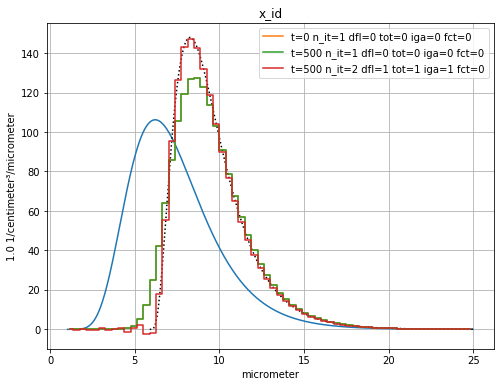

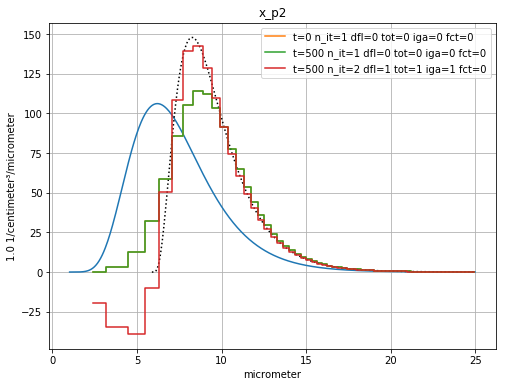

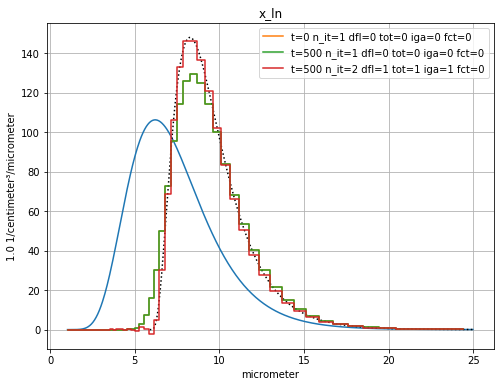

In [24]:
np.seterr(all='raise')
data = run(Setup)

# TODO move somewhere
for fn in data:
    plot = plotter(xmgn(Setup.r_min), xmgn(Setup.r_max))
    # TODO initial and intermidate steps
    plot.pdf_cdf(fmgn(Setup.cdf0, cdfunit))

    plot.step(data[fn][0], 0)

    plot.pdf_pdf(fmgn(Setup.Rogers, yunit))

    for algo in data[fn]:
        plot.step(algo, Setup.nt)
    plot.done(fn.__name__)
